<a href="https://colab.research.google.com/github/karou1182001/NLPAssignments/blob/main/Assignment3/Intro_to_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Intro to Recurrent Neural Networks: Math, Training, and the Copy Task

# Instructor: Dr. Ankur Mali
# University of South Florida (Spring 2025)
### In this tutorial we will build RNNs based on equation and will compare 3 popular frameworks (Jax, TensorFlow and Pytorch)

## Vanilla RNN -- For more in depth explanation refer to your slides

### Forward Pass (Inference) -- Stage 1
Given an input at time \(t\):
\begin{aligned}
\mathbf{x}_t \in \mathbb{R}^{d_{\text{in}}},\quad \mathbf{h}_{t-1} \in \mathbb{R}^{d_{\text{hid}}}
\end{aligned}
we define RNN parameters:
\begin{aligned}
\mathbf{W}_x \in \mathbb{R}^{d_{\text{in}} \times d_{\text{hid}}}, \quad
\mathbf{W}_h \in \mathbb{R}^{d_{\text{hid}} \times d_{\text{hid}}}, \quad
\mathbf{b}_h \in \mathbb{R}^{d_{\text{hid}}}.
\end{aligned}

The hidden state update:
\begin{aligned}
\mathbf{h}_t = \tanh\Bigl(\mathbf{x}_t\,\mathbf{W}_x \;+\;\mathbf{h}_{t-1}\,\mathbf{W}_h \;+\;\mathbf{b}_h\Bigr).
\end{aligned}

Over a sequence  ($\mathbf{x}_1$, $\dots$, $\mathbf{x}_T$), we unroll:
\begin{aligned}
\mathbf{h}_0 = \mathbf{0},\quad
\mathbf{h}_1 = \tanh(\mathbf{x}_1 \mathbf{W}_x + \mathbf{h}_0 \mathbf{W}_h + \mathbf{b}_h),\,\dots,\,
\mathbf{h}_T = \tanh(\mathbf{x}_T \mathbf{W}_x + \mathbf{h}_{T-1} \mathbf{W}_h + \mathbf{b}_h).
\end{aligned}

Optionally, each hidden state  \($\mathbf{h}_t$\) can be projected to the output dimension $d_{\text{in}}$:
\begin{aligned}
\mathbf{\hat{y}}_t = \mathbf{h}_t \mathbf{W}_{\text{out}} + \mathbf{b}_{\text{out}}
\end{aligned}

<!-- $\mathbf{\hat{y}}$_t = $\mathbf{h}_t$,$\mathbf{W}_{\text{out}}$ + $\mathbf{b}_{\text{out}}$. -->


### Remaining Stages
We define a loss (Stage 2) over all time steps, for instance:
\begin{aligned}
\mathbf{L} = \frac{1}{T} \sum_{t=1}^T \left\|\,\mathbf{\hat{y}}_t - \mathbf{y}_t\,\right\|^2,
\end{aligned}
and use Backpropagation Through Time (BPTT) (Stage 3). An optimizer (e.g., Adam) updates parameters (Stage 4):
\begin{aligned}
\theta \,\leftarrow\, \theta \;-\; \eta \,\nabla_\theta \,\mathbf{L}.
\end{aligned}

---

## GRU

### Forward Pass (Inference)
A Gated Recurrent Unit includes reset $\mathbf{r}_t$ and update $\mathbf{z}_t$ gates:

\begin{aligned}
\mathbf{z}_t &= \sigma\!\bigl(\mathbf{x}_t \mathbf{W}_z + \mathbf{h}_{t-1}\,\mathbf{U}_z + \mathbf{b}_z\bigr), \\
\mathbf{r}_t &= \sigma\!\bigl(\mathbf{x}_t \mathbf{W}_r + \mathbf{h}_{t-1}\,\mathbf{U}_r + \mathbf{b}_r\bigr), \\
\tilde{\mathbf{h}}_t &= \tanh\!\bigl(\mathbf{x}_t \mathbf{W}_h + (\mathbf{r}_t \odot \mathbf{h}_{t-1})\,\mathbf{U}_h + \mathbf{b}_h\bigr), \\
\mathbf{h}_t &= (1 - \mathbf{z}_t) \odot \mathbf{h}_{t-1} \;+\; \mathbf{z}_t \odot \tilde{\mathbf{h}}_t.
\end{aligned}

where $\sigma$ is the sigmoid function, and $\odot$ denotes elementwise multiplication.

### Remaining Stages
As in the vanilla RNN, define a loss $\mathbf{L}$ (e.g. MSE). The same BPTT logic applies, but the derivatives now include the GRU gating operations. Parameters (e.g., $\mathbf{W}_z, \mathbf{U}_z, \ldots$ ) are updated by any gradient-based optimizer.

---

## Optimizer
A typical training loop includes:

1. **Forward pass**: compute model outputs $\mathbf{\hat{y}}_t$.
2. **Loss computation**: $\mathbf{L}(\mathbf{\hat{y}}_t, \mathbf{y}_t)$.
3. **Backward pass**: compute $\nabla_\theta \mathbf{L}$ via BPTT.
4. **Parameter update**:
   \begin{aligned}
   \theta \leftarrow \theta - \eta \;\nabla_\theta \,\mathcal{L}.
   \end{aligned}
   (For example, using Adam, SGD, RMSProp, etc.)

---




# The Copy Task
The **copy task** is a simple sequence-to-sequence challenge:

- **Input**: a sequence of random vectors {$\mathbf{x}_1, \dots, \mathbf{x}_T$}.
- **Target**: the **same** sequence {$\mathbf{x}_1, \dots, \mathbf{x}_T$}.

Thus, the model should learn to produce $\mathbf{\hat{y}}_t \approx \mathbf{x}_t$ at each time step ($t$). It's a straightforward yet revealing test of a model’s capacity to retain and reproduce a sequence—particularly sensitive to the model’s ability to **remember** information over time.  

---


# Solution README

Student: Maria Alejandra Zapata Montano

# Objective
The goal of this project is to see how well different recurrent neural network architectures can handle the copy task with different sequence lengths. We’ll train the models on sequences of length T=20 and use validation to find the best hyperparameters. But to really test how well the models generalize, we’ll also test them on longer sequences **(T=100, 200, 500, 1000)** that they haven’t seen before. This will help us figure out if the models are truly learning the task or just memorizing the training data. By looking at how performance drops as the sequence length gets longer, we can find out which architectures are better at handling long term dependencies in sequential data.

#General Structure of the document

The first approach was to first implement all the models and train all of them at the same time. However, I changed because was not optimal.
The structure of the code if that you will see 4 sections
- Standard LSTM
- Multiplicative LSTM
- Standard GRU
- Multiplicative GRU

And each of those will have implemented the sections of implementing the model, the training, validation and evaluation. At the end of all of those you will see the plots with the results and analysis. Just the first model code section will have the Data Generation code, since after this we just reused. And also, you will find there the code to find the best hyperparameters.
Finally and the end of everything we will discuss our results, and how can we improve for future developments.

#Standard LSTM
In this section you will find the implementation of Standard LSTM.
All the othsers follow this structure.

In this part we are just making sure we are connected to the GRU. If not available, we connect to CPU

In [ ]:
import torch

# Verifying if GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

x = torch.rand(1).to(device)
print(f"Tensor in {device}: {x}")


Running on: cuda
GPU: Tesla T4
Tensor in cuda: tensor([0.0038], device='cuda:0')


##1.Implementation of the model

For implementing the model we are using the formulas given by the document and also the structure recommended by code given as a guide

In [1]:
import torch
import torch.nn as nn

#------------------------------------------
# PyTorch Standard LSTM
#------------------------------------------

# ------- Single-Step LSTM Cell
class LSTMCellPyTorch(nn.Module):
    """
    A single-step LSTM cell in PyTorch
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.W_i = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_i = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_i = nn.Parameter(torch.zeros(hidden_size))


        self.W_f = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_f = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_f = nn.Parameter(torch.zeros(hidden_size))


        self.W_o = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_o = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_o = nn.Parameter(torch.zeros(hidden_size))


        self.W_c = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_c = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x_t, h_prev, c_prev):
        """
        x_t: [batch_size, input_size]
        h_prev: [batch_size, hidden_size]
        c_prev: [batch_size, hidden_size]
        """
        i_t = torch.sigmoid(x_t @ self.W_i + h_prev @ self.U_i + self.b_i)
        f_t = torch.sigmoid(x_t @ self.W_f + h_prev @ self.U_f + self.b_f)
        o_t = torch.sigmoid(x_t @ self.W_o + h_prev @ self.U_o + self.b_o)
        c_tilde = torch.tanh(x_t @ self.W_c + h_prev @ self.U_c + self.b_c)


        c_t = f_t * c_prev + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

# ------- Higher-level PyTorch LSTM that unrolls over time
class LSTMPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCellPyTorch(input_size, hidden_size)

        self.W_out = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.b_out = nn.Parameter(torch.zeros(input_size))

    def forward(self, X):
        """
        X: [batch_size, seq_length, input_size]
        """
        batch_size, seq_length, _ = X.shape
        h = torch.zeros(batch_size, self.hidden_size, device=X.device)
        c = torch.zeros(batch_size, self.hidden_size, device=X.device)

        outputs = []
        for t in range(seq_length):
            x_t = X[:, t, :]  # [batch_size, input_size]
            h, c = self.lstm_cell(x_t, h, c)
            out_t = h @ self.W_out + self.b_out
            outputs.append(out_t.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # [batch_size, seq_length, input_size]


##2. Data Generation

Here we are doing the data generation but also the Train/Validation/Test Split.
For the training we use 80% and we use 10% for the validation and 10% for the test.

For the data generation, the sequence are organized this way. We 10 would be our delimitator and the 11 would be the blank space. And the end of this we print some examles of how the data would look like

In [6]:

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

#---------------------------------------------------------------------
# Data Generation
#--------------------------------------------------------------

class CopyTaskDataset(Dataset):
    def __init__(self, sequence_length, vocab_size=10, dataset_size=1000):
        self.sequence_length = sequence_length  # Length of the sc
        self.vocab_size = vocab_size  # NNumber of unique simbols
        self.dataset_size = dataset_size  # Number of total examp
        self.delimiter_token = vocab_size  # Delimitator
        self.blank_token = vocab_size + 1  # Blank space
        self.data, self.targets = self.genData()

    def genData(self):
        data = []
        targets = []

        for _ in range(self.dataset_size):
            # Generate akeatory sequency of int numbers
            seq = np.random.randint(0, self.vocab_size, size=self.sequence_length)

            # Creating entry delimitator and blank spaces
            input_seq = np.concatenate([
                seq,  # or sequences
                [self.delimiter_token],  # Delimitator
                np.full(self.sequence_length, self.blank_token)  # Blank soace
            ])

            # Expected output
            target_seq = np.concatenate([
                np.full(self.sequence_length + 1, self.blank_token),
                seq
            ])

            data.append(input_seq)
            targets.append(target_seq)

        return torch.tensor(np.array(data), dtype=torch.long), torch.tensor(np.array(targets), dtype=torch.long)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# ------- Split Dataset into Train, Validation, and Test Sets
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset


def get_dataloader(sequence_length, vocab_size=10, dataset_size=5000, batch_size=32):
    dataset = CopyTaskDataset(sequence_length, vocab_size, dataset_size)
    train_dataset, val_dataset, test_dataset = split_dataset(dataset)
    return (DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
            DataLoader(test_dataset, batch_size=batch_size, shuffle=False))

# ------- Example
if __name__ == "__main__":
    dataset = CopyTaskDataset(sequence_length=5, vocab_size=10, dataset_size=5)
    for i in range(2):
        print(f"Example {i+1}:")
        print("Input Sequence: ", dataset.data[i].tolist())
        print("Target Sequence: ", dataset.targets[i].tolist())
        print("-" * 20)

Example 1:
Input Sequence:  [0, 9, 2, 9, 2, 10, 11, 11, 11, 11, 11]
Target Sequence:  [11, 11, 11, 11, 11, 11, 0, 9, 2, 9, 2]
--------------------
Example 2:
Input Sequence:  [4, 3, 5, 7, 7, 10, 11, 11, 11, 11, 11]
Target Sequence:  [11, 11, 11, 11, 11, 11, 4, 3, 5, 7, 7]
--------------------


## 3. Training

## Training and Validation Loss Plots

This function is the one we call in all the code. It is for plotting the data and comparing the epoch vs the loss and the accuracy vs the epoch.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    # Plot loss curves
    plt.figure(figsize=(7, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Val Loss")
    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracies, label="Val Accuracy")
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


LSTM Training with Hyperparameter Search and Validation:
In this function we are doing the training. We are using as a guide the code given in class but we have made some edits in order it can find the best hyperparameters and also to save the values for the plotting. After finding the best hyperparameters we do the training and validation with the best one. This best hyperparameters would be use in all the models.


Searching hyperparameters

Testing Config: Hidden=64, Batch=16, LR=0.001, Epochs=10
Epoch 1/10, Train Loss: 1.4219, Train Accuracy: 53.92%, Val Loss: 1.1736, Val Accuracy: 56.04%
Epoch 2/10, Train Loss: 1.1561, Train Accuracy: 56.15%, Val Loss: 1.1445, Val Accuracy: 56.10%
Epoch 3/10, Train Loss: 1.1437, Train Accuracy: 56.15%, Val Loss: 1.1342, Val Accuracy: 56.06%
Epoch 4/10, Train Loss: 1.1311, Train Accuracy: 56.15%, Val Loss: 1.1288, Val Accuracy: 56.12%
Epoch 5/10, Train Loss: 1.1270, Train Accuracy: 56.28%, Val Loss: 1.1249, Val Accuracy: 56.36%
Epoch 6/10, Train Loss: 1.1252, Train Accuracy: 56.32%, Val Loss: 1.1226, Val Accuracy: 56.53%
Epoch 7/10, Train Loss: 1.1258, Train Accuracy: 56.25%, Val Loss: 1.1255, Val Accuracy: 56.12%
Epoch 8/10, Train Loss: 1.1230, Train Accuracy: 56.33%, Val Loss: 1.1213, Val Accuracy: 56.31%
Epoch 9/10, Train Loss: 1.1154, Train Accuracy: 56.42%, Val Loss: 1.1099, Val Accuracy: 56.43%
Epoch 10/10, Train Loss: 1.1085, Train Accuracy: 56.64%, Val

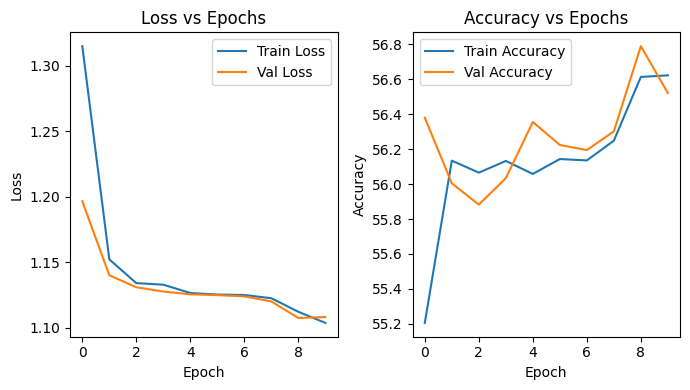


Training ended in136.56 s


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
import numpy as np
from torch.utils.data import DataLoader

#------------------------------------------------------
# PyTorch Benchmark
#---------------------------------------------------
def benchmark_pytorch(input_size, hidden_size, train_loader, val_loader, epochs, lr, plot=False):
    model = LSTMPyTorch(input_size, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # For plot
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training Phase
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)


            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            optimizer.zero_grad()
            outputs = model(inputs)


            loss = criterion(outputs.view(-1, input_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # accuracy
            predictions = outputs.argmax(dim=-1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

        train_accuracy = (correct / total) * 100
        avg_train_loss = total_loss / len(train_loader)

        # For plot
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, input_size), targets.view(-1))
                val_loss += loss.item()
                predictions = outputs.argmax(dim=-1)
                val_correct += (predictions == targets).sum().item()
                val_total += targets.numel()

        val_accuracy = (val_correct / val_total) * 100
        avg_val_loss = val_loss / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if plot:
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)

    return model, time.time() - start_time, avg_train_loss, avg_val_loss

# ------------------------------------------------------
# Hyperparameter Search
# ------------------------------------------------------
def hyperparameter_search(train_loader, val_loader, num_combinations=15):
    param_space = {
        "hidden_size": [64, 128],
        "batch_size": [16, 32],
        "learning_rate": [0.001],
        "epochs": [10],
    }

    total_combinations = len(param_space["hidden_size"]) * len(param_space["batch_size"]) * len(param_space["learning_rate"]) * len(param_space["epochs"])
    num_combinations = min(num_combinations, total_combinations)
    sampled_configs = random.sample(
        [(h, b, lr, e) for h in param_space["hidden_size"]
                      for b in param_space["batch_size"]
                      for lr in param_space["learning_rate"]
                      for e in param_space["epochs"]], num_combinations)

    best_config = None
    best_loss = float("inf")

    for config in sampled_configs:
        h_size, b_size, lr, e = config
        print(f"\nTesting Config: Hidden={h_size}, Batch={b_size}, LR={lr}, Epochs={e}")

        train_loader, val_loader, _ = get_dataloader(sequence_length=20, batch_size=b_size)
        _, _, final_loss, _ = benchmark_pytorch(input_size=12, hidden_size=h_size, train_loader=train_loader, val_loader=val_loader, epochs=e, lr=lr, plot=False)

        if final_loss < best_loss:
            best_loss = final_loss
            best_config = config

    print(f"\n Best conf: {best_config}")
    return best_config

# ------------------------------------------------------
# Run Training and Save Model
# ------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
train_loader, val_loader, _ = get_dataloader(sequence_length=20, batch_size=32)  # train/val sets

print("\nSearching hyperparameters")
best_hyperparams = hyperparameter_search(train_loader, val_loader, num_combinations=2)
print("\nBest hyperparameters found. Training model")

best_h_size, best_b_size, best_lr, best_epochs = best_hyperparams
train_loader, val_loader, _ = get_dataloader(sequence_length=20, batch_size=best_b_size)

best_model, training_time, _, _ = benchmark_pytorch(input_size=12, hidden_size=best_h_size, train_loader=train_loader, val_loader=val_loader, epochs=best_epochs, lr=best_lr, plot=True)

torch.save(best_model.state_dict(), "best_model.pth")

print(f"\nTraining ended in{training_time:.2f} s")


### Analysis

Best Hyperparameters Selected:
- Hidden Size: 128
- Batch Size: 16
- Learning Rate: 0.001
- Epochs: 10

These hyperparameters were chosen after evaluating different configurations during the hyperparameter search process. The final training configuration was selected because it resulted in a reasonable trade off between training loss, validation loss, and accuracy.


The results from the Standard LSTM model show that during the 10 training epochs show that the model is learning, as both training and validation loss decrease over time. The training accuracy starts at 55.21% and improves to 56.62%, while the validation accuracy stays between 56.00% and 56.79%. Even in the graphs we can observe these results


## 4. Evaluation

In the evaluation we are getting the mean accuracy and standard error

In [16]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import sem

# ------------------------------------------------------
# Evaluate model
# ------------------------------------------------------
def evaluate_model(model, test_loader, input_size):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            predictions = model(inputs)
            loss = loss_fn(predictions.view(-1, input_size), targets.view(-1))
            total_loss += loss.item()

            # accuracy
            predicted_labels = predictions.argmax(dim=-1)
            total_correct += (predicted_labels == targets).sum().item()
            total_samples += targets.numel()

    accuracy = (total_correct / total_samples) * 100
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

def full_evaluation(model, input_size, sequence_lengths=[100, 200, 500, 1000], trials=3):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = {}
    print("\nEvaluating")

    trial_accuracies = {T: [] for T in sequence_lengths}

    for T in sequence_lengths:
        print(f"Evaluating in T={T}")

        _, _, test_loader = get_dataloader(sequence_length=T, batch_size=best_b_size)

        for _ in range(trials):
            loss, accuracy = evaluate_model(model, test_loader, input_size)
            trial_accuracies[T].append(accuracy)

    results = {
        T: {
            "mean_accuracy": np.mean(trial_accuracies[T]),
            "std_error": sem(trial_accuracies[T])
        } for T in sequence_lengths
    }

    print("\nResults:")
    for T, metrics in results.items():
        print(f"T={T}: Accuracy={metrics['mean_accuracy']:.2f}% ± {metrics['std_error']:.2f}%")

    return results

# ------------------------------------------------------
# Load Trained Model and Execute Evaluation
# ------------------------------------------------------
print("\nGetting trained model")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 12

best_model = LSTMPyTorch(input_size=input_size, hidden_size=best_h_size).to(device)

best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.eval()

print("\ Eval model")

evaluation_results = full_evaluation(best_model, input_size)
print("\nEvaluation completed!")



Getting trained model
\ Eval model

Evaluating
Evaluating in T=100


<ipython-input-16-26db8d092d2f>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pth", map_location=device))


Evaluating in T=200
Evaluating in T=500
Evaluating in T=1000

Results:
T=100: Accuracy=42.15% ± 0.00%
T=200: Accuracy=43.33% ± 0.00%
T=500: Accuracy=49.08% ± 0.00%
T=1000: Accuracy=52.40% ± 0.00%

Evaluation completed!


The results show that the accuracy of the model is decent across all sequence lengths. For T=100, accuracy is 42.15%, and it slightly improves as T increases, reaching 52.40% at T=1000. This suggests that the model got better results with bigger ones.

#  Multiplicative LSTM

## 1.Implementation of the model

For implementing the model we are using the formulas given by the document and also the structure recommended by code given as a guide

In [30]:
import torch
import torch.nn as nn

#--------------------------------------------------------
# PyTorch Implementation of Multiplicative LSTM
#------------------------------------------------------

# ------- Single-Step Multiplicative LSTM Cell
class MLSTMCellPyTorch(nn.Module):
    """
    A single-step Multiplicative LSTM cell in PyTorch
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.W_m = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_m = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_m = nn.Parameter(torch.zeros(hidden_size))

        #This was to make the sizes match
        self.W_x = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)

        self.W_i = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.U_i = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        self.W_f = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.U_f = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        self.W_o = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.U_o = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

        self.W_c = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.U_c = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        self.W_proj = nn.Linear(hidden_size, input_size)

    def forward(self, x_t, h_prev, c_prev):
        """
        x_t: [batch_size, input_size]
        h_prev: [batch_size, hidden_size]
        c_prev: [batch_size, hidden_size]
        """
        x_proj = x_t @ self.W_x

        m_t = x_t @ self.W_m + h_prev @ self.U_m + self.b_m

        x_tilde = m_t * x_proj

        i_t = torch.sigmoid(x_tilde @ self.W_i + h_prev @ self.U_i + self.b_i)
        f_t = torch.sigmoid(x_tilde @ self.W_f + h_prev @ self.U_f + self.b_f)
        o_t = torch.sigmoid(x_tilde @ self.W_o + h_prev @ self.U_o + self.b_o)
        c_tilde = torch.tanh(x_tilde @ self.W_c + h_prev @ self.U_c + self.b_c)


        c_t = f_t * c_prev + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

# ------- Higher-level PyTorch MLSTM that unrolls over time
class MLSTMPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.mlstm_cell = MLSTMCellPyTorch(input_size, hidden_size)

        self.W_out = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.b_out = nn.Parameter(torch.zeros(input_size))

    def forward(self, X):
        """
        X: [batch_size, seq_length, input_size]
        """
        batch_size, seq_length, _ = X.shape
        h = torch.zeros(batch_size, self.hidden_size, device=X.device)
        c = torch.zeros(batch_size, self.hidden_size, device=X.device)

        outputs = []
        for t in range(seq_length):
            x_t = X[:, t, :]
            h, c = self.mlstm_cell(x_t, h, c)
            out_t = h @ self.W_out + self.b_out
            outputs.append(out_t.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # [batch_size, seq_length, input_size]


## 3. Model Training

The model training

Epoch 1/10, Train Loss: 1.2797, Train Accuracy: 55.46%, Val Loss: 1.1297, Val Accuracy: 56.08%
Epoch 2/10, Train Loss: 1.1253, Train Accuracy: 56.37%, Val Loss: 1.1218, Val Accuracy: 56.83%
Epoch 3/10, Train Loss: 1.1177, Train Accuracy: 57.17%, Val Loss: 1.1062, Val Accuracy: 58.12%
Epoch 4/10, Train Loss: 1.0813, Train Accuracy: 59.74%, Val Loss: 1.0631, Val Accuracy: 60.23%
Epoch 5/10, Train Loss: 1.0441, Train Accuracy: 60.85%, Val Loss: 1.0254, Val Accuracy: 61.19%
Epoch 6/10, Train Loss: 0.9942, Train Accuracy: 61.89%, Val Loss: 0.9735, Val Accuracy: 62.40%
Epoch 7/10, Train Loss: 0.9580, Train Accuracy: 62.75%, Val Loss: 0.9399, Val Accuracy: 63.31%
Epoch 8/10, Train Loss: 0.9225, Train Accuracy: 64.17%, Val Loss: 0.9118, Val Accuracy: 64.64%
Epoch 9/10, Train Loss: 0.8933, Train Accuracy: 65.36%, Val Loss: 0.8822, Val Accuracy: 66.05%
Epoch 10/10, Train Loss: 0.8643, Train Accuracy: 66.38%, Val Loss: 0.8575, Val Accuracy: 67.02%


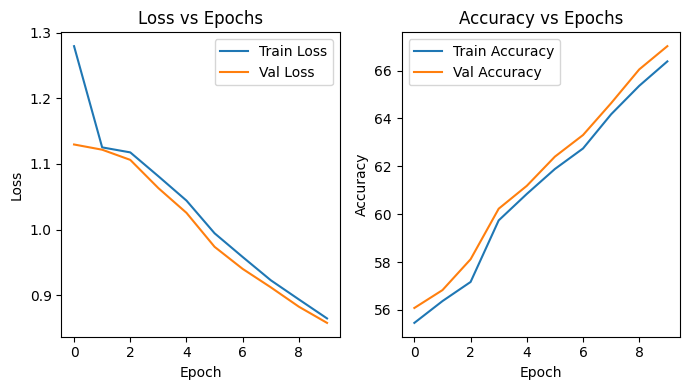


Training ended in196.34 s


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
import numpy as np
from torch.utils.data import DataLoader

#------------------------------------------------------
# PyTorch Benchmark
#---------------------------------------------------
def benchmark_pytorch(input_size, hidden_size, train_loader, val_loader, epochs, lr, plot=False):
    model = MLSTMPyTorch(input_size, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # For plot
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training Phase
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)


            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            optimizer.zero_grad()
            outputs = model(inputs)


            loss = criterion(outputs.view(-1, input_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # accuracy
            predictions = outputs.argmax(dim=-1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

        train_accuracy = (correct / total) * 100
        avg_train_loss = total_loss / len(train_loader)

        # For plot
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, input_size), targets.view(-1))
                val_loss += loss.item()
                predictions = outputs.argmax(dim=-1)
                val_correct += (predictions == targets).sum().item()
                val_total += targets.numel()

        val_accuracy = (val_correct / val_total) * 100
        avg_val_loss = val_loss / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if plot:
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)

    return model, time.time() - start_time, avg_train_loss, avg_val_loss



# ------- Training Standard GRU with Best Hyperparameters
np.random.seed(42)
torch.manual_seed(42)

train_loader, val_loader, _ = get_dataloader(sequence_length=20, batch_size=best_b_size)

best_model, training_time, _, _ = benchmark_pytorch(input_size=12, hidden_size=best_h_size, train_loader=train_loader, val_loader=val_loader, epochs=best_epochs, lr=best_lr, plot=True)

torch.save(best_model.state_dict(), "best_model_mLSTM.pth")

print(f"\nTraining ended in{training_time:.2f} s")



The training results show an improvement. Both train and validation loss decrease, indicating that the model is learning well. Accuracy improves from 55.46% to 66.38% (train) and 56.08% to 67.02% (validation) over 10 epochs. The validation accuracy is close to training accuracy.

## 4. Model Evaluation

In [34]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import sem

# ------------------------------------------------------
# Evaluate model
# ------------------------------------------------------
def evaluate_model(model, test_loader, input_size):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            predictions = model(inputs)
            loss = loss_fn(predictions.view(-1, input_size), targets.view(-1))
            total_loss += loss.item()

            # accuracy
            predicted_labels = predictions.argmax(dim=-1)
            total_correct += (predicted_labels == targets).sum().item()
            total_samples += targets.numel()

    accuracy = (total_correct / total_samples) * 100
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

def full_evaluation(model, input_size, sequence_lengths=[100, 200, 500, 1000], trials=3):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = {}
    print("\nEvaluating")

    trial_accuracies = {T: [] for T in sequence_lengths}

    for T in sequence_lengths:
        print(f"Evaluating in T={T}")
        _, _, test_loader = get_dataloader(sequence_length=T, batch_size=best_b_size)
        for _ in range(trials):
            loss, accuracy = evaluate_model(model, test_loader, input_size)
            trial_accuracies[T].append(accuracy)

    results = {
        T: {
            "mean_accuracy": np.mean(trial_accuracies[T]),
            "std_error": sem(trial_accuracies[T])
        } for T in sequence_lengths
    }

    print("\nResults:")
    for T, metrics in results.items():
        print(f"T={T}: Accuracy={metrics['mean_accuracy']:.2f}% ± {metrics['std_error']:.2f}%")

    return results

# ------------------------------------------------------
# Load Trained Model and Execute Evaluation
# ------------------------------------------------------
print("\nGetting trained model")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 12
best_model =  MLSTMPyTorch(input_size=input_size, hidden_size=best_h_size).to(device)
best_model.load_state_dict(torch.load("best_model_mLSTM.pth", map_location=device))
best_model.eval()

print("\n Eval model")

evaluation_results = full_evaluation(best_model, input_size)
print("\nEvaluation completed!")



Getting trained model

 Eval model

Evaluating
Evaluating in T=100


<ipython-input-34-13ddc6ce4cbd>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model_mLSTM.pth", map_location=device))


Evaluating in T=200
Evaluating in T=500
Evaluating in T=1000

Results:
T=100: Accuracy=52.92% ± 0.00%
T=200: Accuracy=51.47% ± 0.00%
T=500: Accuracy=50.57% ± 0.00%
T=1000: Accuracy=50.29% ± 0.00%

Evaluation completed!


For T=100, the accuracy is 52.92%, but for longer sequences as T=1000 if performed not that well. However, in general we got better results than the standard

# Standard GRU

## 1.Implementation of the model

In [35]:
import torch
import torch.nn as nn

#----------------------------------------
# PyTorch Implementation of Standard GRU
#----------------------------------------

# ------- Single-Step GRU Cell
class GRUCellPyTorch(nn.Module):
    """
    A single-step GRU cell in PyTorch
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size


        self.W_z = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_z = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_z = nn.Parameter(torch.zeros(hidden_size))


        self.W_r = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_r = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_r = nn.Parameter(torch.zeros(hidden_size))


        self.W_h = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_h = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x_t, h_prev):
        """
        x_t: [batch_size, input_size]
        h_prev: [batch_size, hidden_size]
        """
        z_t = torch.sigmoid(x_t @ self.W_z + h_prev @ self.U_z + self.b_z)
        r_t = torch.sigmoid(x_t @ self.W_r + h_prev @ self.U_r + self.b_r)
        h_tilde = torch.tanh(x_t @ self.W_h + (r_t * h_prev) @ self.U_h + self.b_h)

        h_t = (1 - z_t) * h_prev + z_t * h_tilde

        return h_t

# ------- Higher-level PyTorch GRU that unrolls over time
class GRUPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru_cell = GRUCellPyTorch(input_size, hidden_size)

        self.W_out = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.b_out = nn.Parameter(torch.zeros(input_size))

    def forward(self, X):
        """
        X: [batch_size, seq_length, input_size]
        """
        batch_size, seq_length, _ = X.shape
        h = torch.zeros(batch_size, self.hidden_size, device=X.device)

        outputs = []
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.gru_cell(x_t, h)
            out_t = h @ self.W_out + self.b_out
            outputs.append(out_t.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # [batch_size, seq_length, input_size]


## 3. Model Training

Training with Validation

Epoch 1/10, Train Loss: 1.2823, Train Accuracy: 54.95%, Val Loss: 1.1568, Val Accuracy: 56.21%
Epoch 2/10, Train Loss: 1.1401, Train Accuracy: 56.08%, Val Loss: 1.1317, Val Accuracy: 56.24%
Epoch 3/10, Train Loss: 1.1291, Train Accuracy: 56.21%, Val Loss: 1.1263, Val Accuracy: 56.70%
Epoch 4/10, Train Loss: 1.1222, Train Accuracy: 56.92%, Val Loss: 1.1123, Val Accuracy: 58.20%
Epoch 5/10, Train Loss: 1.0939, Train Accuracy: 59.08%, Val Loss: 1.0796, Val Accuracy: 59.98%
Epoch 6/10, Train Loss: 1.0704, Train Accuracy: 60.35%, Val Loss: 1.0649, Val Accuracy: 60.78%
Epoch 7/10, Train Loss: 1.0484, Train Accuracy: 61.32%, Val Loss: 1.0343, Val Accuracy: 62.02%
Epoch 8/10, Train Loss: 1.0155, Train Accuracy: 62.69%, Val Loss: 1.0035, Val Accuracy: 63.04%
Epoch 9/10, Train Loss: 0.9853, Train Accuracy: 63.87%, Val Loss: 0.9728, Val Accuracy: 64.54%
Epoch 10/10, Train Loss: 0.9544, Train Accuracy: 65.10%, Val Loss: 0.9411, Val Accuracy: 65.76%


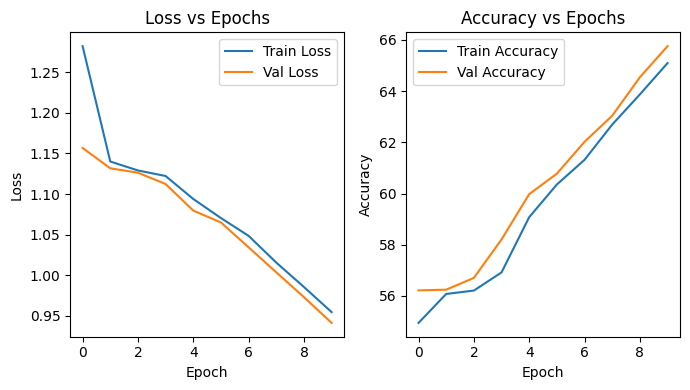


Training ended in131.30 s


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
import numpy as np
from torch.utils.data import DataLoader

#------------------------------------------------------
# PyTorch Benchmark
#---------------------------------------------------
def benchmark_pytorch(input_size, hidden_size, train_loader, val_loader, epochs, lr, plot=False):
    model = GRUPyTorch(input_size, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # For plot
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training Phase
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)


            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            optimizer.zero_grad()
            outputs = model(inputs)


            loss = criterion(outputs.view(-1, input_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # accuracy
            predictions = outputs.argmax(dim=-1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

        train_accuracy = (correct / total) * 100
        avg_train_loss = total_loss / len(train_loader)

        # For plot
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, input_size), targets.view(-1))
                val_loss += loss.item()
                predictions = outputs.argmax(dim=-1)
                val_correct += (predictions == targets).sum().item()
                val_total += targets.numel()

        val_accuracy = (val_correct / val_total) * 100
        avg_val_loss = val_loss / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if plot:
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)

    return model, time.time() - start_time, avg_train_loss, avg_val_loss



# ------- Run Benchmark for Standard GRU with Best Hyperparameters
np.random.seed(42)
torch.manual_seed(42)

train_loader, val_loader, _ = get_dataloader(sequence_length=20, batch_size=best_b_size)

best_model, training_time, _, _ = benchmark_pytorch(input_size=12, hidden_size=best_h_size, train_loader=train_loader, val_loader=val_loader, epochs=best_epochs, lr=best_lr, plot=True)

torch.save(best_model.state_dict(), "best_model_GRU.pth")

print(f"\nTraining ended in{training_time:.2f} s")



### Analysis of Model
The training results for the standard GRU show a clear improvement over the 10 epochs. Both train and validation loss decrease, indicating that the model is learning well. Training accuracy increases from 54.95% to 65.10%, while validation accuracy improves from 56.21% to 65.76%. In comparison with the other models, this got good results.

## 4. Evaluation

In [37]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import sem

# ------------------------------------------------------
# Evaluate model
# ------------------------------------------------------
def evaluate_model(model, test_loader, input_size):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            predictions = model(inputs)
            loss = loss_fn(predictions.view(-1, input_size), targets.view(-1))
            total_loss += loss.item()

            # accuracy
            predicted_labels = predictions.argmax(dim=-1)
            total_correct += (predicted_labels == targets).sum().item()
            total_samples += targets.numel()

    accuracy = (total_correct / total_samples) * 100
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

def full_evaluation(model, input_size, sequence_lengths=[100, 200, 500, 1000], trials=3):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = {}
    print("\nEvaluating")

    trial_accuracies = {T: [] for T in sequence_lengths}

    for T in sequence_lengths:
        print(f"Evaluating in T={T}")
        _, _, test_loader = get_dataloader(sequence_length=T, batch_size=best_b_size)
        for _ in range(trials):
            loss, accuracy = evaluate_model(model, test_loader, input_size)
            trial_accuracies[T].append(accuracy)

    results = {
        T: {
            "mean_accuracy": np.mean(trial_accuracies[T]),
            "std_error": sem(trial_accuracies[T])
        } for T in sequence_lengths
    }

    print("\nResults:")
    for T, metrics in results.items():
        print(f"T={T}: Accuracy={metrics['mean_accuracy']:.2f}% ± {metrics['std_error']:.2f}%")

    return results

# ------------------------------------------------------
# Load Trained Model and Execute Evaluation
# ------------------------------------------------------
print("\nGetting trained model")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 12
best_model =  GRUPyTorch(input_size=input_size, hidden_size=best_h_size).to(device)
best_model.load_state_dict(torch.load("best_model_GRU.pth", map_location=device))
best_model.eval()

print("\n Eval model")

evaluation_results = full_evaluation(best_model, input_size)
print("\nEvaluation completed")



Getting trained model

 Eval model

Evaluating
Evaluating in T=100


<ipython-input-37-e81438b1e1bd>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model_GRU.pth", map_location=device))


Evaluating in T=200
Evaluating in T=500
Evaluating in T=1000

Results:
T=100: Accuracy=55.30% ± 0.00%
T=200: Accuracy=55.09% ± 0.00%
T=500: Accuracy=55.03% ± 0.00%
T=1000: Accuracy=55.02% ± 0.00%

Evaluation completed


In all of the sequences this model got similar results, suggesting that maintain performance.

# Multiplicative GRU

## 1.Implementation of the model

In [40]:
import torch
import torch.nn as nn

#----------------------------------------------
# PyTorch Implementation of Multiplicative GRU
#----------------------------------------------

# ------- Single Step Multiplicative GRU Cell
class MGRUCellPyTorch(nn.Module):
    """
    A single-step Multiplicative GRU cell in PyTorch.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.W_m = nn.Parameter(torch.randn(input_size, input_size) * 0.1)
        self.U_m = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.b_m = nn.Parameter(torch.zeros(input_size))

        self.W_z = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_z = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_z = nn.Parameter(torch.zeros(hidden_size))

        self.W_r = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_r = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_r = nn.Parameter(torch.zeros(hidden_size))

        self.W_h = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.U_h = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x_t, h_prev):
        """
        x_t: [batch_size, input_size]
        h_prev: [batch_size, hidden_size]
        """
        m_t = x_t @ self.W_m + h_prev @ self.U_m + self.b_m

        x_tilde = m_t * x_t

        z_t = torch.sigmoid(x_tilde @ self.W_z + h_prev @ self.U_z + self.b_z)
        r_t = torch.sigmoid(x_tilde @ self.W_r + h_prev @ self.U_r + self.b_r)
        h_tilde = torch.tanh(x_tilde @ self.W_h + (r_t * h_prev) @ self.U_h + self.b_h)

        h_t = (1 - z_t) * h_prev + z_t * h_tilde

        return h_t

# ------- Higher-level PyTorch MGRU that unrolls over time
class MGRUPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.mgru_cell = MGRUCellPyTorch(input_size, hidden_size)

        self.W_out = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.b_out = nn.Parameter(torch.zeros(input_size))

    def forward(self, X):
        """
        X: [batch_size, seq_length, input_size]
        """
        batch_size, seq_length, _ = X.shape
        h = torch.zeros(batch_size, self.hidden_size, device=X.device)

        outputs = []
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.mgru_cell(x_t, h)
            out_t = h @ self.W_out + self.b_out
            outputs.append(out_t.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # [batch_size, seq_length, input_size]


## 3. Model Training

Training with Validation

Epoch 1/10, Train Loss: 1.3056, Train Accuracy: 55.60%, Val Loss: 1.1471, Val Accuracy: 57.15%
Epoch 2/10, Train Loss: 1.1228, Train Accuracy: 58.31%, Val Loss: 1.1066, Val Accuracy: 58.77%
Epoch 3/10, Train Loss: 1.0773, Train Accuracy: 59.99%, Val Loss: 1.0429, Val Accuracy: 61.00%
Epoch 4/10, Train Loss: 1.0216, Train Accuracy: 61.80%, Val Loss: 1.0063, Val Accuracy: 62.02%
Epoch 5/10, Train Loss: 0.9848, Train Accuracy: 62.87%, Val Loss: 0.9619, Val Accuracy: 63.68%
Epoch 6/10, Train Loss: 0.9406, Train Accuracy: 64.32%, Val Loss: 0.9268, Val Accuracy: 64.95%
Epoch 7/10, Train Loss: 0.9075, Train Accuracy: 65.22%, Val Loss: 0.8972, Val Accuracy: 65.28%
Epoch 8/10, Train Loss: 0.8797, Train Accuracy: 65.88%, Val Loss: 0.8713, Val Accuracy: 65.74%
Epoch 9/10, Train Loss: 0.8475, Train Accuracy: 66.84%, Val Loss: 0.8430, Val Accuracy: 66.81%
Epoch 10/10, Train Loss: 0.8230, Train Accuracy: 67.71%, Val Loss: 0.8153, Val Accuracy: 67.95%


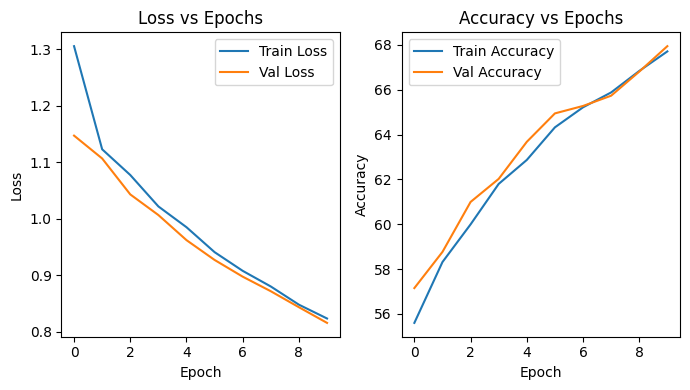


Training ended in151.78 s


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
import numpy as np
from torch.utils.data import DataLoader

#------------------------------------------------------
# PyTorch Benchmark
#---------------------------------------------------
def benchmark_pytorch(input_size, hidden_size, train_loader, val_loader, epochs, lr, plot=False):
    model = MGRUPyTorch(input_size, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # For plot
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training Phase
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)


            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            optimizer.zero_grad()
            outputs = model(inputs)


            loss = criterion(outputs.view(-1, input_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # accuracy
            predictions = outputs.argmax(dim=-1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

        train_accuracy = (correct / total) * 100
        avg_train_loss = total_loss / len(train_loader)

        # For plot
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, input_size), targets.view(-1))
                val_loss += loss.item()
                predictions = outputs.argmax(dim=-1)
                val_correct += (predictions == targets).sum().item()
                val_total += targets.numel()

        val_accuracy = (val_correct / val_total) * 100
        avg_val_loss = val_loss / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if plot:
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)

    return model, time.time() - start_time, avg_train_loss, avg_val_loss



# ------- Run Benchmark for Standard GRU with Best Hyperparameters
np.random.seed(42)
torch.manual_seed(42)

train_loader, val_loader, _ = get_dataloader(sequence_length=20, batch_size=best_b_size)

best_model, training_time, _, _ = benchmark_pytorch(input_size=12, hidden_size=best_h_size, train_loader=train_loader, val_loader=val_loader, epochs=best_epochs, lr=best_lr, plot=True)

torch.save(best_model.state_dict(), "best_model_mGRU.pth")

print(f"\nTraining ended in{training_time:.2f} s")



The results are showing how consistent improvement over 10 epochs. Training accuracy increases from 55.60% to 67.71%, while validation accuracy improves from 57.15% to 67.95%. Both train and validation loss decrease, indicating effective learning

## 4. Model Evaluation

In [42]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import sem

# ------------------------------------------------------
# Evaluate model
# ------------------------------------------------------
def evaluate_model(model, test_loader, input_size):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            predictions = model(inputs)
            loss = loss_fn(predictions.view(-1, input_size), targets.view(-1))
            total_loss += loss.item()

            # accuracy
            predicted_labels = predictions.argmax(dim=-1)
            total_correct += (predicted_labels == targets).sum().item()
            total_samples += targets.numel()

    accuracy = (total_correct / total_samples) * 100
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

def full_evaluation(model, input_size, sequence_lengths=[100, 200, 500, 1000], trials=3):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = {}
    print("\nEvaluating")

    trial_accuracies = {T: [] for T in sequence_lengths}

    for T in sequence_lengths:
        print(f"Evaluating in T={T}")
        _, _, test_loader = get_dataloader(sequence_length=T, batch_size=best_b_size)
        for _ in range(trials):
            loss, accuracy = evaluate_model(model, test_loader, input_size)
            trial_accuracies[T].append(accuracy)

    results = {
        T: {
            "mean_accuracy": np.mean(trial_accuracies[T]),
            "std_error": sem(trial_accuracies[T])
        } for T in sequence_lengths
    }

    print("\nResults:")
    for T, metrics in results.items():
        print(f"T={T}: Accuracy={metrics['mean_accuracy']:.2f}% ± {metrics['std_error']:.2f}%")

    return results

# ------------------------------------------------------
# Load Trained Model and Execute Evaluation
# ------------------------------------------------------
print("\nGetting trained model")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 12
best_model =  MGRUPyTorch(input_size=input_size, hidden_size=best_h_size).to(device)
best_model.load_state_dict(torch.load("best_model_mGRU.pth", map_location=device))
best_model.eval()

print("\n Eval model")

evaluation_results = full_evaluation(best_model, input_size)
print("\nEvaluation completed")



Getting trained model

 Eval model

Evaluating
Evaluating in T=100


<ipython-input-42-caf628cca8a5>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model_mGRU.pth", map_location=device))


Evaluating in T=200
Evaluating in T=500
Evaluating in T=1000

Results:
T=100: Accuracy=54.47% ± 0.00%
T=200: Accuracy=53.90% ± 0.00%
T=500: Accuracy=53.70% ± 0.00%
T=1000: Accuracy=53.61% ± 0.00%

Evaluation completed


The results for the Multiplicative GRU model show consistent accuracy across different sequence lengths. The accuracy remains stable, ranging from 54.47% at T=100 to 53.61% at T=1000. This suggests that the model performs similarly regardless of sequence length

# Conclusion

The Multiplicative GRU was the best model for the Copy Task, showing the highest accuracy in both training and a similar to the others in evaluation, but multiplicative LSTM got very similar results.

I consider that it was the best because it balances memory and efficiency. GRU already learns faster than LSTM because it has fewer parameters, and adding multiplicative connections helped it remember sequences better
All models improved during training, but multiplicative LSTM and GRU remembered sequences better than their standard versions. Standard LSTM had the lowest accuracy, meaning it struggled with longer sequences. Multiplicative LSTM was better, but Multiplicative GRU was the strongest. I think that using multiplicative connections helps models remember information longer.
Also, testing with different hyperparameters can help us in a future improving the results.

But with all of this we learned a lot of the process of training, testing and validation. Finding best hyperparameters, implementing models with mathematical formulas and comparing their results.